This is a list of the finishers of the Boston Marathon of 2013. It contains the name, age, gender, country, city and state (where available), times at different stages of the race, expected time, finish time and pace, overall place, gender place and division place.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation

from sklearn.metrics import silhouette_score
%matplotlib inline

In [2]:
df = pd.read_csv('boston_marathon_2013.csv', encoding = 'ISO-8859-1')

In [3]:
df.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.9,9,38.8,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.9,M,64.9,132.50,1,NaN,...,5,5.07,NaN,92.97,15.9,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.9,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.5,32,"Fearnley, Kurt H.",5,18.73,M,42,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [11]:
df.shape

(16164, 21)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [4]:
df.drop('ctz', axis=1, inplace = True)

In [5]:
#0 is for Females, 1 for Males
df['gender'] = df['gender'].map({'F':0,'M':1})

In [20]:
df.gender.value_counts()

1    9680
0    6484
Name: gender, dtype: int64

The columns '5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k' are times at different stages of race. these should be floats.

In [6]:
race_stages = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for race_stage in race_stages:
    df[race_stage] = pd.to_numeric(df[race_stage], errors='coerce')
   

In [27]:
df.isnull().sum()

25k            23
age             0
name            0
division        0
10k            26
gender          0
half           16
official        0
bib             0
country         0
overall         0
pace            0
state        1463
30k            17
5k             66
genderdiv       0
20k            17
35k            21
city            1
40k            17
dtype: int64

replace the NAN values for these columns

In [7]:
race_stages = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for race_stage in race_stages:
    df[race_stage] = df[race_stage].fillna(np.mean(df[race_stage]))


In [8]:
df.drop(['country', 'city', 'state'], axis=1, inplace = True)

In [9]:
df.drop(['name', 'bib'], axis=1, inplace = True)

In [10]:
df.isnull().sum()

25k          0
age          0
division     0
10k          0
gender       0
half         0
official     0
overall      0
pace         0
30k          0
5k           0
genderdiv    0
20k          0
35k          0
40k          0
dtype: int64

In [11]:
X = df

now let's normalize the data and create a 2-feature PCA for graphing purposes.

In [12]:
Xn = normalize(X)
print(len(Xn))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xn)

16164


Now, lets separate the data into four equal sets for cross validation.

In [13]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    Xn,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)
# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

4041 4041
4041 4041
4041 4041
4041 4041


# K Means Modeling
Now, let's create two data frames, one for storing the y predictions from the kmeans model, and the second for the silhouette scores for the different clusters, and then model for 2-5 clusters, storing silhouette scores for each.

In [14]:
# Initialize data frames
ypred_df = pd.DataFrame()
scores_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    
    # Creating a list of possible number of clusters to test in kmeans.
    for n_cluster in range(2, 6): 
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred_df['cluster ' + str(n_cluster) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = silhouette_score(data[0], labels, metric='euclidean')
        scores_df = scores_df.append({'cluster_pred':'cluster ' + str(n_cluster) + '_sample ' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)    

In [15]:
scores_df.sort_values(by='cluster_pred', ascending=False)

,cluster_pred,sil_score
15,cluster 5_sample 3,0.632052
11,cluster 5_sample 2,0.637345
7,cluster 5_sample 1,0.542933
3,cluster 5_sample 0,0.542883
14,cluster 4_sample 3,0.628909
10,cluster 4_sample 2,0.633950
6,cluster 4_sample 1,0.632414
2,cluster 4_sample 0,0.630449
13,cluster 3_sample 3,0.597593
9,cluster 3_sample 2,0.597731


Cluster 2, 3 and 4 have consistent scores across the 4 sets, with cluster 4 being the highest scorer.

In [16]:
mean_score = scores_df.loc[scores_df['cluster_pred'].str.contains('cluster 4'),'sil_score'].mean()

In [17]:
model_comp_df = pd.DataFrame(columns=['Model','score'])
model_comp_df = model_comp_df.append({'Model' : 'KMeans' , 'score' : mean_score}, ignore_index=True)


# Mean-shift clustering

use a range of quantiles to create the bandwidths, from 0.1 to 0.4, store silhouette scores for each.

In [19]:
ypred_ms_df = pd.DataFrame()
score_ms_df = pd.DataFrame(columns=['cluster_pred','sil_score', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms_df['cluster ' + str(cntrs) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = silhouette_score(data, labels, metric='euclidean')
        score_ms_df = score_ms_df.append({'cluster_pred':'cluster ' + str(cntrs) + '_sample ' + str(counter), 
                              'sil_score':sscore, 'quantile':n}, ignore_index=True)

In [20]:
score_ms_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score,quantile
11,cluster 2_sample 2,0.680383,0.4
15,cluster 2_sample 3,0.663110,0.4
9,cluster 5_sample 2,0.633842,0.2
2,cluster 5_sample 0,0.630451,0.3
6,cluster 6_sample 1,0.630331,0.3
10,cluster 4_sample 2,0.628465,0.3
4,cluster 6_sample 1,0.628166,0.1
0,cluster 6_sample 0,0.628103,0.1
5,cluster 5_sample 1,0.627634,0.2
1,cluster 4_sample 0,0.626366,0.2


The quantile of 0.4 had a high silhouette score for sample 2 which created 2 clusters.

In [21]:
score_ms_df.sort_values(by='cluster_pred', ascending=False)

,cluster_pred,sil_score,quantile
8,cluster 9_sample 2,0.560390,0.1
12,cluster 7_sample 3,0.552774,0.1
4,cluster 6_sample 1,0.628166,0.1
6,cluster 6_sample 1,0.630331,0.3
0,cluster 6_sample 0,0.628103,0.1
9,cluster 5_sample 2,0.633842,0.2
5,cluster 5_sample 1,0.627634,0.2
2,cluster 5_sample 0,0.630451,0.3
13,cluster 4_sample 3,0.625117,0.2
14,cluster 4_sample 3,0.625790,0.3


# Spectral Clustering
Now, let's analyse spectral clustering model, using a range of clusters from 2-5, and checking silhouette scores for each.

In [85]:
ypred_spc_df = pd.DataFrame()
score_spc_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_spc_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_spc_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_spc_df['cluster ' + str(nclust) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = silhouette_score(data[0], labels, metric='euclidean')
        score_spc_df = score_spc_df.append({'cluster_pred':'cluster ' + str(nclust) + '_sample ' + str(counter), 
                              'sil_score':sscore_sc}, ignore_index=True)

In [86]:
score_spc_df.sort_values(by='cluster_pred', ascending=False)

,cluster_pred,sil_score
15,cluster 5_sample 3,0.619911
11,cluster 5_sample 2,0.627577
7,cluster 5_sample 1,0.620172
3,cluster 5_sample 0,0.616948
14,cluster 4_sample 3,0.628163
10,cluster 4_sample 2,0.632745
6,cluster 4_sample 1,0.631549
2,cluster 4_sample 0,0.629161
13,cluster 3_sample 3,0.578277
9,cluster 3_sample 2,0.558629


Cluster 2 and 4 have consistent scores across the 4 sets, with cluster 4 being the highest scorer.

In [90]:
mean_score = score_spc_df.loc[score_spc_df['cluster_pred'].str.contains('cluster 4'),'sil_score'].mean()
model_comp_df = model_comp_df.append({'Model' : 'Spectral' , 'score' : mean_score}, ignore_index=True)

In [92]:
model_comp_df

,Model,score
0,KMeans,0.631431
1,Spectral,0.630405


# Affinity Propagation

In [57]:
# Initialize data frame
score_ap_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    
    labels = af.labels_
    sscore_af = silhouette_score(data, labels, metric='euclidean')
    score_ap_df = score_ap_df.append({'cluster_pred':'cluster ' + str(n_clusters_) + '_sample ' + str(counter), 
                              'sil_score':sscore_af}, ignore_index=True)

In [59]:
score_ap_df.sort_values(by ='sil_score', ascending = False )

,cluster_pred,sil_score
0,cluster 1251_sample 0,0.198838
1,cluster 1553_sample 1,0.163766
2,cluster 2433_sample 2,0.119086
3,cluster 2760_sample 3,0.094374


This model predicted absurd number of clusters, and had a very less silhouette score.

In [93]:
model_comp_df

,Model,score
0,KMeans,0.631431
1,Spectral,0.630405


# Summary of Models
Overall, the 4 cluster solution have the highest silhouette scores, and the silhouette scores for the four-cluster solutions were highest for the k-means models, with a silhouette score of 0.631. This means that there are four main groups of runners in the Boston Marathon.

In [22]:
X.head()

,25k,age,division,10k,gender,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,49.87,28,9,18.18,1,40.93,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55
1,77.27,30,5,30.90,1,64.90,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77
2,77.23,23,1,30.90,1,64.92,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78
3,50.50,32,5,18.73,1,42.00,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43
4,48.75,39,3,18.18,1,40.57,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88


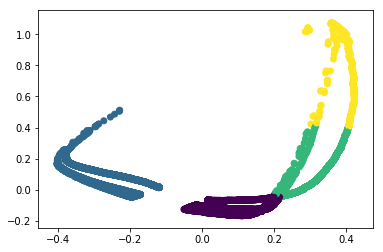

In [99]:
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
km = KMeans(n_clusters=4, random_state=42).fit(X_pca)
labels = km.labels_
X['cluster'] = labels
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'])
plt.show()



In [100]:
X.head()

,25k,age,division,10k,gender,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,cluster
0,49.87,28,9,18.18,1,40.93,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55,3
1,77.27,30,5,30.90,1,64.90,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77,3
2,77.23,23,1,30.90,1,64.92,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78,3
3,50.50,32,5,18.73,1,42.00,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43,3
4,48.75,39,3,18.18,1,40.57,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88,3


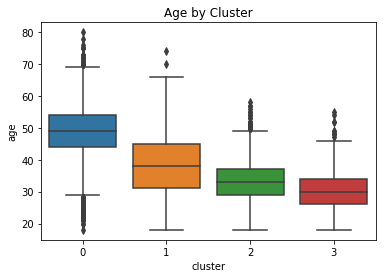

In [110]:
sns.boxplot(x='cluster', y='age', data=X)
plt.title('Age by Cluster')
plt.show()

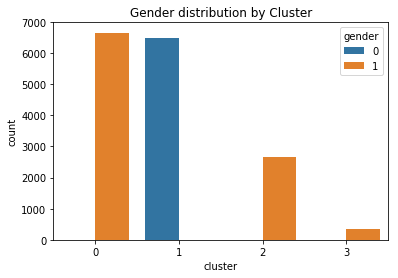

In [117]:
sns.countplot(x = 'cluster', hue='gender', data=X)
plt.title('Gender distribution by Cluster')
plt.show()

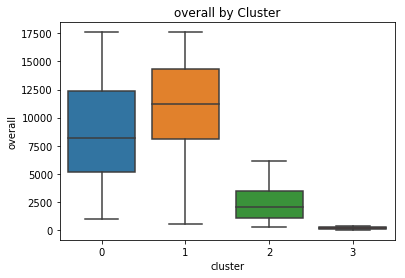

In [118]:
sns.boxplot(x='cluster', y='overall', data=X)
plt.title('overall by Cluster')
plt.show()

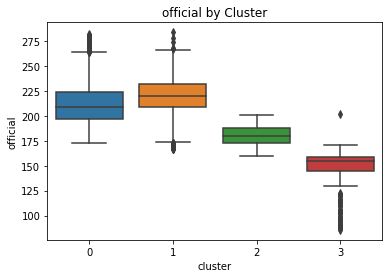

In [119]:
sns.boxplot(x='cluster', y='official', data=X)
plt.title('official by Cluster')
plt.show()